In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import numpy as np

In [22]:
plt.figure(3)
def show_state(env, step=0, info=""):
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import numpy as np
import os
import ray
import time

import gym

# Define some hyperparameters.

# The number of hidden layer neurons.
H = 200
learning_rate = 1e-4
# Discount factor for reward.
gamma = 0.99
# The decay factor for RMSProp leaky sum of grad^2.
decay_rate = 0.99

# The input dimensionality: 80x80 grid.
D = 80 * 80

In [2]:
ray.init(redis_address="192.168.2.16:6379")

{'local_scheduler_socket_names': [u'/tmp/scheduler40728902'],
 'node_ip_address': '192.168.2.16',
 'object_store_addresses': [ObjectStoreAddress(name=u'/tmp/plasma_store94765772', manager_name=u'/tmp/plasma_manager22479115', manager_port=56935)],
 'redis_address': '192.168.2.16:6379'}

In [3]:
def sigmoid(x):
    # Sigmoid "squashing" function to interval [0, 1].
    return 1.0 / (1.0 + np.exp(-x))


def preprocess(I):
    """Preprocess 210x160x3 uint8 frame into 6400 (80x80) 1D float vector."""
    # Crop the image.
    I = I[35:195]
    # Downsample by factor of 2.
    I = I[::2, ::2, 0]
    # Erase background (background type 1).
    I[I == 144] = 0
    # Erase background (background type 2).
    I[I == 109] = 0
    # Set everything else (paddles, ball) to 1.
    I[I != 0] = 1
    return I.astype(np.float).ravel()


def discount_rewards(r):
    """take 1D float array of rewards and compute discounted reward"""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        # Reset the sum, since this was a game boundary (pong specific!).
        if r[t] != 0:
            running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


def policy_forward(x, model):
    h = np.dot(model["W1"], x)
    h[h < 0] = 0  # ReLU nonlinearity.
    logp = np.dot(model["W2"], h)
    p = sigmoid(logp)
    # Return probability of taking action 2, and hidden state.
    return p, h


def policy_backward(eph, epx, epdlogp, model):
    """backward pass. (eph is array of intermediate hidden states)"""
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model["W2"])
    # Backprop relu.
    dh[eph <= 0] = 0
    dW1 = np.dot(dh.T, epx)
    return {"W1": dW1, "W2": dW2}


@ray.remote
class PongEnv(object):
    def __init__(self):
        # Tell numpy to only use one core. If we don't do this, each actor may
        # try to use all of the cores and the resulting contention may result
        # in no speedup over the serial version. Note that if numpy is using
        # OpenBLAS, then you need to set OPENBLAS_NUM_THREADS=1, and you
        # probably need to do it from the command line (so it happens before
        # numpy is imported).
        os.environ["MKL_NUM_THREADS"] = "1"
        self.env = gym.make("Pong-v0")
        #self.step = 0

    def compute_gradient(self, model):
        # Reset the game.
        observation = self.env.reset()
        # Note that prev_x is used in computing the difference frame.
        prev_x = None
        xs, hs, dlogps, drs = [], [], [], []
        reward_sum = 0
        done = False
        while not done:
            cur_x = preprocess(observation)
            x = cur_x - prev_x if prev_x is not None else np.zeros(D)
            prev_x = cur_x

            aprob, h = policy_forward(x, model)
            # Sample an action.
            action = 2 if np.random.uniform() < aprob else 3

            # The observation.
            xs.append(x)
            # The hidden state.
            hs.append(h)
            y = 1 if action == 2 else 0  # A "fake label".
            # The gradient that encourages the action that was taken to be
            # taken (see http://cs231n.github.io/neural-networks-2/#losses if
            # confused).
            dlogps.append(y - aprob)

            observation, reward, done, info = self.env.step(action)
            #show_state(self.env.env,self.step)
            #self.step += 1
            reward_sum += reward

            # Record reward (has to be done after we call step() to get reward
            # for previous action).
            drs.append(reward)

        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        # Reset the array memory.
        xs, hs, dlogps, drs = [], [], [], []

        # Compute the discounted reward backward through time.
        discounted_epr = discount_rewards(epr)
        # Standardize the rewards to be unit normal (helps control the gradient
        # estimator variance).
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)
        # Modulate the gradient with advantage (the policy gradient magic
        # happens right here).
        epdlogp *= discounted_epr
        return policy_backward(eph, epx, epdlogp, model), reward_sum

In [15]:
def build_model():
    model = {}
    # "Xavier" initialization.
    model["W1"] = np.random.randn(H, D) / np.sqrt(D)
    model["W2"] = np.random.randn(H) / np.sqrt(H)
    return model

In [16]:
def train(model,iterations,batch_size):
    batch_num = 1
    running_reward = None
    # Update buffers that add up gradients over a batch.
    grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}
    # Update the rmsprop memory.
    rmsprop_cache = {k: np.zeros_like(v) for k, v in model.items()}
    
    iteration = 0
    while iteration != iterations:
        iteration += 1
        model_id = ray.put(model)
        actions = []
        # Launch tasks to compute gradients from multiple rollouts in parallel.
        start_time = time.time()
        for i in range(batch_size):
            action_id = actors[i].compute_gradient.remote(model_id)
            actions.append(action_id)
        for i in range(batch_size):
            action_id, actions = ray.wait(actions)
            grad, reward_sum = ray.get(action_id[0])
            # Accumulate the gradient over batch.
            for k in model:
                grad_buffer[k] += grad[k]
            running_reward = (reward_sum if running_reward is None
                          else running_reward * 0.99 + reward_sum * 0.01)
        end_time = time.time()
        print("Batch {} computed {} rollouts in {} seconds, "
              "running mean is {}".format(batch_num, batch_size,
                                      end_time - start_time,
                                      running_reward))
        #update the weights in model
        for k, v in model.items():
            g = grad_buffer[k]
            rmsprop_cache[k] = (decay_rate * rmsprop_cache[k] +
                            (1 - decay_rate) * g ** 2)
            model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
            # Reset the batch gradient buffer.
            grad_buffer[k] = np.zeros_like(v)
        batch_num += 1
    return model

In [17]:
actors = [PongEnv.remote() for _ in range(batch_size)]

In [30]:
trained_model = train(model,iterations=10,batch_size=10)

Batch 1 computed 10 rollouts in 26.6310689449 seconds, running mean is -20.9034201591
Batch 2 computed 10 rollouts in 25.2465641499 seconds, running mean is -20.845293824
Batch 3 computed 10 rollouts in 24.103525877 seconds, running mean is -20.801558894
Batch 4 computed 10 rollouts in 24.1876318455 seconds, running mean is -20.7422912882
Batch 5 computed 10 rollouts in 26.1251189709 seconds, running mean is -20.6595855133
Batch 6 computed 10 rollouts in 25.3931407928 seconds, running mean is -20.6450314882
Batch 7 computed 10 rollouts in 27.2821509838 seconds, running mean is -20.6503336782
Batch 8 computed 10 rollouts in 23.8418519497 seconds, running mean is -20.5598049225
Batch 9 computed 10 rollouts in 30.248401165 seconds, running mean is -20.4105473266
Batch 10 computed 10 rollouts in 27.3127698898 seconds, running mean is -20.3991738569


In [31]:
def play(frames=100):
    os.environ["MKL_NUM_THREADS"] = "1"
    env = gym.make("Pong-v0")

    # Run a demo of the environment
    observation = env.reset()
    
    prev_x = None
    done = False
    for t in range(frames):
        cur_x = preprocess(observation)
        x = cur_x - prev_x if prev_x is not None else np.zeros(D)
        prev_x = cur_x
        aprob, h = policy_forward(x, model)
        action = 2 if np.random.uniform() < aprob else 3
        #action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        show_state(env.env,t)
        if done:
            break
    env.render(close=True)

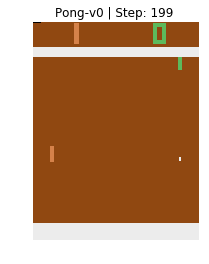

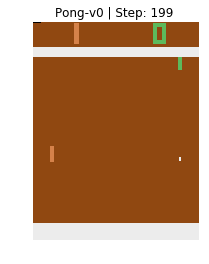

In [32]:
play(frames=200)